# Modelling a strictly periodic time series signal

This notebook takes us through the application of the puffins model for strictly periodic signals in time series data as applied to astronomical time series of eclipsing binary stars. 

The specific use case is that of U Gru, an eclipsing binary with a pulsating A-type primary star and a low mass, bloated, post mass transfer K-type giant for the secondary in a 1.855 d orbit. In the original case, the eclipse signal couldn't be uniquely modelled with PHOEBE because we didn't have enough data (specifically, we were missing spectra of the secondary, so we couldn't find a unique mass ratio). Furthermore, there is an apparent time-dependent deviation from the raw binary model that is likely caused by circum stellar/binary material that is adding a non-negligible amount of light to the system. 

Due to the improper model and lack of data, we were unable to get a full binary solution for publishing and had to remove the binary signal with a spline interpolation - which leaves much to be desired. To further complicate things, the spline interpolation required us to bin the data non-uniformly, with special attention to times of sharp variation. This workflow is hard to generalize because each binary is different, and so we wanted to come up with a simple, fast, and flexible model to efficiently remove the binary signal from a lightcurve to then investigate the residuals. 

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
# import lightkurve as lk

from pythia.timeseries.lombscargle import LS_periodogram
from puffins.utils import get_design_matrix
from puffins.solver import solve
from puffins.weight_functions import matern32

np.random.seed(8675309) # MAGIC to enforce reproducibility
RCOND = 1e-14 # MAGIC input to `np.linalg.lstsq()`
plotnum=1

Let's download / unpack the data

In [2]:
# Un-comment this if you want to use lightkurve to get your data
# search = lk.search_lightcurve('U Gru', cadence=120)
# lc = search[-1].download().remove_nans().remove_outliers().normalize()
# time = lc.time.value
# flux = lc.flux.value

# Otherwise, this is much quicker
time, flux = np.loadtxt('../data/ugru.dat').T
print(len(time))

15000


Let's take a look at the raw data

Text(0, 0.5, 'Normalized Flux')

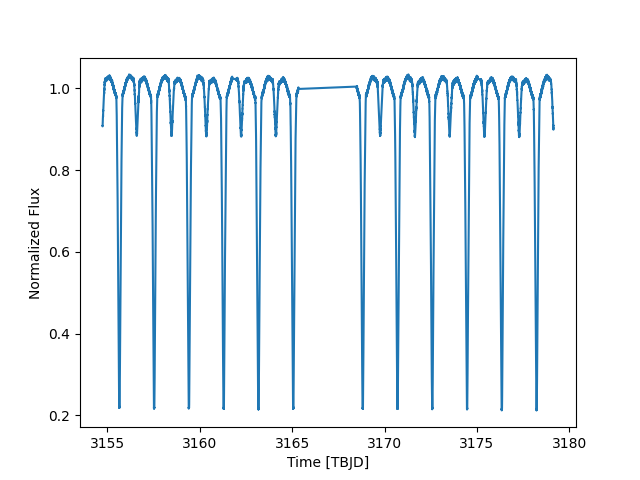

In [3]:
fig_lc, ax_lc = plt.subplots(num=plotnum)
plotnum += 1
ax_lc.plot(time, flux)
ax_lc.set_xlabel('Time [TBJD]')
ax_lc.set_ylabel('Normalized Flux')

And now let's look at the periodogram

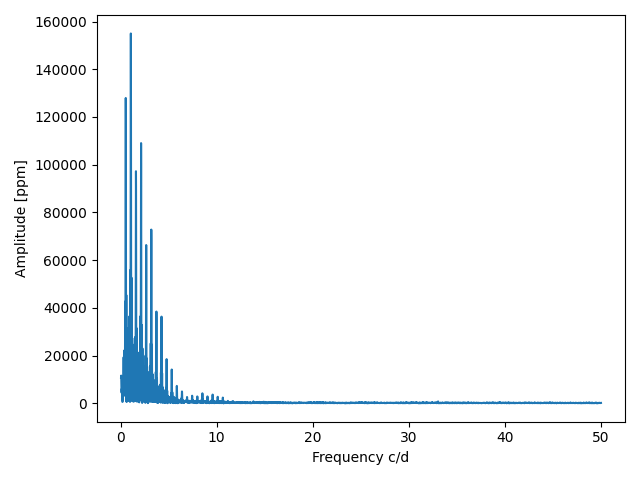

In [4]:
nu, amp = LS_periodogram(time, flux-np.median(flux), max=50)
fig, ax = plt.subplots(num=plotnum)
plotnum += 1
ax.plot(nu, amp*1e6)
ax.set_xlabel('Frequency c/d')
ax.set_ylabel('Amplitude [ppm]')
fig.tight_layout()
plt.savefig('ugru_periodogram.png')

## Harmonic forest

All we see is a series of harmonics at integer multiples of the binary orbital frequency - this is a result of the highly non-sinusoidal nature of the eclipse signal. 

Good - we can't see anything except for harmoinics. 
This is exactly what we want to fix!

Below, we have some functions that create a design matrix
with a Fourier basis and we use that to solve for a linear
model that predicts the sum-total of the binary behaviour 
that is described by a harmonic series.

In [5]:
period = 1.88045

In [ ]:
# From Hogg notebook


def weight_function_mat32(omegas, width):
    """
    This function is chosen because we know the F.T. of its square.

    ## comments:
    - The "width" is in spatial separation, so it is really an inverse width here
    in Fourier space.

    """
    return 1. / (width ** 2 * omegas ** 2 + 1.)


def train_feature_weighted_ols(xs, ys, ws=None):
    n, p = xs.shape
    if ws is None:
        ws = np.ones(p)
    return np.linalg.lstsq(xs * ws[None, :], ys, rcond=RCOND)[0].T * ws


def train_feature_weighted_wls(xs, ys, Lambdadiag=None, Cdiag=None):
  n, p = xs.shape
  if Lambdadiag is None:
    Lambdadiag = np.ones(p)
  if Cdiag is None:
    Cdiag = np.ones(n)
  if p < n:
    XTCinv = xs.T / Cdiag
    XTCinvX = XTCinv @ xs
    XTCinvX[np.diag_indices(p)] += Lambdadiag
    return np.linalg.lstsq(XTCinvX, XTCinv @ ys, rcond=RCOND)[0]
  LinvXT = (xs / Lambdadiag).T
  XLinvXT = xs @ LinvXT
  XLinvXT[np.diag_indices(n)] += Cdiag
  return LinvXT @ np.linalg.lstsq(XLinvXT, ys, rcond=RCOND)[0]

In [10]:
K = 300

X, omegas= get_design_matrix(time, period, K)

# Do this with a simple linear regression
betas_wls = solve(X, flux, method='wls', W=None)

# Now, let's try a Ridge Regression because why not
betas_ridge = solve(X, flux,  method='ridge', alpha=1, W=None)

# We can also do this with a feature weighted OLS
betas_fw = solve(X, flux, method='fw', W=None, L=matern32(omegas, 1./period))

betas_hogg = train_feature_weighted_ols(X, flux, ws=weight_function_mat32(omegas, 1.))

In [8]:
# Reconstruct the predicted flux based on our linear models
predicted_wls = X @ betas_wls
predicted_ridge = X @ betas_ridge
predicted_fw = X @ betas_fw
predicted_hogg = X @ betas_hogg

resid_wls = flux - predicted_wls
resid_ridge = flux - predicted_ridge
resid_fw = flux - predicted_fw
resid_hogg = flux - predicted_hogg
diff_fwhogg = predicted_fw - predicted_hogg

In [15]:
print(betas_wls[:7])
print(betas_ridge[:7])
print(betas_fw[:7])
print(betas_hogg[:50]-betas_ridge[:50])


[ 0.93193172 -0.08005274 -0.09329644  0.02938602 -0.14585621  0.07471981
 -0.04029963]
[ 0.93186845 -0.08003734 -0.09328322  0.02937961 -0.14583541  0.07471263
 -0.04029608]
[ 0.93186907 -0.08004536 -0.09329189  0.02938341 -0.14585279  0.07472102
 -0.04030056]
[ 6.32683816e-05 -1.54004325e-05 -1.32238716e-05  6.40988828e-06
 -2.07987930e-05  7.18497902e-06 -3.55229127e-06  1.22548032e-05
  3.23316698e-06  7.82624632e-07  8.31330592e-06 -3.90587830e-06
  5.49128107e-06 -5.26581373e-06  1.52088526e-06 -2.98311408e-06
 -3.39236322e-06 -9.31561190e-08 -2.04743735e-06  1.40213236e-06
 -6.78072110e-07  4.00027958e-07  6.43322134e-07  2.68649420e-07
  7.72866292e-08 -2.21473584e-07  7.95483789e-07 -2.16344675e-07
  2.45481010e-07 -3.69363320e-07 -3.47733091e-07  3.15429534e-08
 -7.58161917e-08  5.83042754e-07 -3.83290169e-07  2.78727501e-07
  3.64637462e-07  1.63323114e-07  8.48800273e-08  3.98168662e-07
  2.67734130e-07 -4.76675372e-07  1.47200705e-07  3.01822897e-07
 -2.16751239e-07  3.3495

In [ ]:
# Now we want to calculate a periodogram of the residuals and see
# if we can identify any new features (i.e., pulsations) that 
# were previously hiding under the harmonic forest from the binary

nu_wls, amp_wls = LS_periodogram(time, resid_wls-np.median(resid_wls), max=50)
nu_ridge, amp_ridge = LS_periodogram(time, resid_ridge-np.median(resid_ridge), max=50)
nu_fw, amp_fw = LS_periodogram(time, resid_fw-np.median(resid_fw), max=50)
nu_hogg, amp_hogg = LS_periodogram(time, resid_hogg-np.median(resid_hogg), max=50)


In [ ]:
plotnum+=1
fig_, ax_ = plt.subplots(num=plotnum)
# ax_.plot(nu, amp*1e6, 'k')
# ax_.plot(nu_rr, amp_rr*1e6, 'k')
ax_.plot(nu_fw, amp_fw*1e6, 'k')
ax_.plot(nu_wls, amp_wls*1e6, 'b')
ax_.plot(nu_hogg, amp_hogg*1e6, 'r')
ax_.set_xlabel('Frequency [c/d]')
ax_.set_ylabel('Amplitude [ppm]')
fig_.tight_layout()
plt.savefig('ugru_residual_periodogram.png')


So, we see something - but it's not perfect. There is still a lot of residual power in harmonics of the binary frequency, but both the simple
linear regression and the Ridge Regression give the same answer. 

We might have to get creative with improving this. Is the problem in the sharp features around eclipse?

In [ ]:
plotnum += 1
fig_, ax_ = plt.subplots(num=plotnum)
ph = (time/period)%1
ax_.plot(ph, flux, 'o', color='grey', alpha=0.05)
# ax_.plot(ph, predicted_fw, 'k.')
ax_.plot(ph, predicted_fw - predicted_wls, 'r.')
ax_.set_xlabel('Orbital Phase')
ax_.set_ylabel('Noramlized Flux')

In [ ]:
def ols_solve(X,y, weights=None):
    n, p = X.shape
    if weights is None:
        weights = np.ones(n)
    XTCinv = X.T * weights
    
    return np.linalg.solve( XTCinv @ X, XTCinv @ y)


def ols_lstsq(X, y, weights=None, rcond=1e-14):
    n, p = X.shape
    if weights is None:
        weights = np.ones(n)
    XTCinv = X.T * weights
    return np.linalg.lstsq(XTCinv @ X, XTCinv @ y, rcond=rcond)[0]


def ols_direct(X, y, weights=None):
    n, p = X.shape
    if weights is None:
        weights = np.ones(n)
    XTCinv = X.T * weights
    return np.linalg.inv(XTCinv @ X) @ XTCinv @ y

In [ ]:
betas_solve = ols_solve(X, flux)
betas_lstsq = ols_lstsq(X, flux)
betas_direct = ols_direct(X, flux)

syn_solve = X @ betas_solve
syn_lstsq = X @ betas_lstsq
syn_dir = X @ betas_direct

plotnum += 1
fig_, ax_ = plt.subplots(num=plotnum)
ax_.plot(time, syn_lstsq, 'k-')
ax_.plot(time, syn_lstsq, 'r-')
ax_.plot(time, syn_dir, 'b-')
ax_.plot(time, flux, 'o', color='grey', alpha=0.05)

plt.show()

In [ ]:
print(betas_solve[:4])
print(betas_lstsq[:4])
print(betas_direct[:4])

In [ ]:
syn_dir - syn_solve

In [ ]:
syn_lstsq - syn_solve